# [10] CNN 돌리기 (CNN Activatioon)

In [1]:
# CIFAR10 데이터 
# 설명 : 10개 클래스  ,5만개 train image , 1만개 test image

# 맥락

1. `Imports` 라이브러리
2. `transforms data` 수행가능한 데이터 만들기(performing)
3. `batch size` 세팅하기 train,test 셋 다운로드하기.
4. validation 20% 로 대략설정하여 데이터를 sampler 로 나누기
5. `DataLoader()` 함수로 각 세트의 배치정하기
6. 구조 정의하기. (Define the architecture of your network)
7. 파라미터정의하기.(epoch 도 정의)
8. 실제로 모델 학습시키기. loss 와 accuracy 계산.
9. Plot 으로 그래프그리기.


## Data Augmentation (데이터증강)

`-` 중요성 : 1. 숫자가 많으면 학습이 잘된다.(데이터부족해결, 일반화 성능향상, 과적합 방지) 그래서 여러 변형을 주며 데이터증강을 할 필요가 있다.

# 코드

In [2]:
import numpy as np
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),
                                         (0.5,0.5,0.5))])

In [4]:
batch_size=100

train_data =datasets.CIFAR10('data',train=True, 
                             download=True,
                             transform=transform)
test_data =datasets.CIFAR10('data',train=False, 
                             download=True,
                             transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(dev_size * len(train_data)))
train_idx,dev_idx = idx[split_size:],idx[:split_size]

train_sampler = SubsetRandomSampler(train_idx) #훈련셋 무작위 선택
dev_sampler = SubsetRandomSampler(dev_idx)

# 현재과정은 test 셋은 나두고 train셋을 8:2 로 나누어
#dev 셋에서 학습 성능을 검증하기 위해 만든 세트입니다.

In [6]:
train_loader = \
torch.utils.data.DataLoader(train_data,
                            batch_size=batch_size,
                            sampler=train_sampler)
dev_loader = \
torch.utils.data.DataLoader(train_data,
                            batch_size=batch_size,
                            sampler=dev_sampler)
test_loader = \
torch.utils.data.DataLoader(test_data,
                            batch_size=batch_size)

#이게 기초
```python
class CNN(nn.Module): #Pytorch 의 모든 신경망 모델의 상속 모델이다.
    def __init__(self):
        super(CNN, self).__init__()
        # 모델의 레이어들을 여기에 정의

    def forward(self, x):
        # 순전파 동작을 여기에 정의
        return x
```

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 모델의 레이어들을 여기에 정의
        self.conv1 = nn.Conv2d(3,10,3,1,1)
        self.conv2 = nn.Conv2d(10,20,3,1,1)
        self.conv3 = nn.Conv2d(20,40,3,1,1)
        self.pool = nn.MaxPool2d(2,2)

        self.linear1 = nn.Linear(40*4*4,100)
        self.linear2 = nn.Linear(100,10)
        self.dropout = nn.Dropout(0.2)

    
    def forward(self, x):
        # 순전파 동작을 여기에 정의
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))


        x = x.view(-1,40*4*4)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        return x


In [8]:
model = CNN().to("cuda")
loss_function = nn.NLLLoss() #negative log-likelihood)
optimizer = optim.Adam(model.parameters(),lr=0.001)
epochs = 50

In [9]:
train_losses , dev_losses, train_acc , dev_acc = [],[],[],[]
x_axis = []

for e in range(1, epochs+1):
    losses = 0
    acc=0
    iterations = 0
    
    model.train()
    
    # train loader 를 이용하여 배치 루프 돌리기
    for data, target in train_loader:
        iterations += 1 
        
        #forward , backard
        pred =model(data.to("cuda"))
        loss = loss_function(pred,target.to("cuda"))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        p = torch.exp(pred)
        top_p , top_class = p.topk(1,dim=1)
        acc += accuracy_score(target.to("cpu"),top_class.to("cpu"))
    
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
    
    if e%5 ==0 or e ==1 :
        x_axis.append(e)
        
        with torch.no_grad(): #gradient descent 계산 중단하여 평가모델로 전환하기.
            model.eval() #model.eval()은 PyTorch에서 모델을 평가(evaluation) 모드로 전환하는 메서드입니다. 
            #모델을 학습 중에 사용되는 드롭아웃(Dropout)과 배치 정규화(Batch Normalization)와 같은 층을 평가모드로 전환합니다.
            
            for data_dev , target_dev in dev_loader:
                iter_2 += 1
                
                dev_pred = model(data_dev.to("cuda"))
                dev_loss = loss_function(dev_pred,target_dev.to("cuda"))
                dev_losss += dev_loss.item()
                
                dev_p = torch.exp(dev_pred)
                top_p , dev_top_class = dev_p.topk(1,dim=1)
                dev_accs += accuracy_score(target_dev.to("cpu"), dev_top_class.to("cpu"))
            
            
        train_losses.append(losses/iterations)
        dev_losses.append(dev_losss/iter_2)
        train_acc.append(acc/iterations)
        dev_acc.append(dev_accs/iter_2)
        
        print("Epoch: {}/{}..".format(e,epochs),
              "Training Loss: {:.3f}.. "\
              .format(losses/iterations),
              "Validation Loss: {:.3f}.."\
              .format(dev_losss/iter_2),
              "Training Accuracy: {:.3f}.. "\
              .format(acc/iterations),
              "Validation Accuracy: {:.3f}"\
              .format(dev_accs/iter_2))
              

/root/anaconda3/envs/deep/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1/50.. Training Loss: 1.717..  Validation Loss: 1.440.. Training Accuracy: 0.370..  Validation Accuracy: 0.474
Epoch: 5/50.. Training Loss: 1.194..  Validation Loss: 1.139.. Training Accuracy: 0.573..  Validation Accuracy: 0.590
Epoch: 10/50.. Training Loss: 0.995..  Validation Loss: 0.968.. Training Accuracy: 0.647..  Validation Accuracy: 0.657
Epoch: 15/50.. Training Loss: 0.881..  Validation Loss: 0.889.. Training Accuracy: 0.686..  Validation Accuracy: 0.684
Epoch: 20/50.. Training Loss: 0.803..  Validation Loss: 0.848.. Training Accuracy: 0.711..  Validation Accuracy: 0.702
Epoch: 25/50.. Training Loss: 0.755..  Validation Loss: 0.840.. Training Accuracy: 0.730..  Validation Accuracy: 0.706
Epoch: 30/50.. Training Loss: 0.711..  Validation Loss: 0.820.. Training Accuracy: 0.743..  Validation Accuracy: 0.714
Epoch: 35/50.. Training Loss: 0.678..  Validation Loss: 0.827.. Training Accuracy: 0.757..  Validation Accuracy: 0.710
Epoch: 40/50.. Training Loss: 0.658..  Validation 

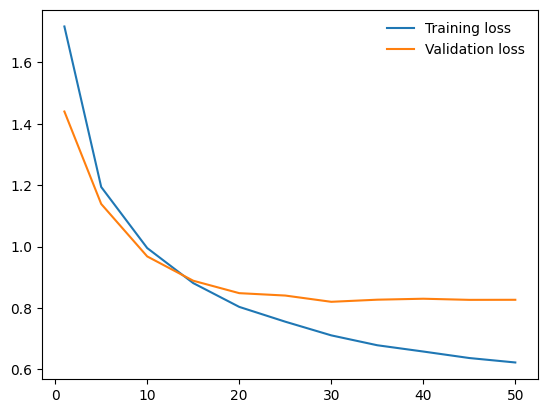

In [10]:
plt.plot(x_axis,train_losses , label='Training loss')
plt.plot(x_axis,dev_losses, label='Validation loss')
plt.legend(frameon=False) #plot 의 테두리 그릴지 여부
plt.show()

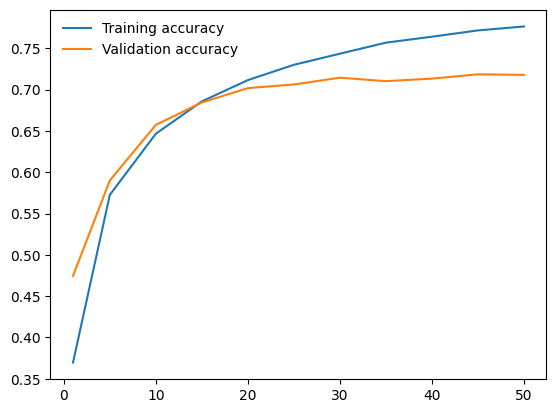

In [12]:
plt.plot(x_axis , train_acc , label = "Training accuracy")
plt.plot(x_axis, dev_acc , label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [15]:
# validation 에서도 연습해봤고 이제 test set 에 직접적인 accuracy 계산하기
model.eval() # 평가모드
iter_3 = 0
acc_test = 0

for data_test, target_test in test_loader:
    iter_3 += 1
    test_pred = model(data_test.to("cuda"))
    test_pred = torch.exp(test_pred)
    top_p , top_class_test = test_pred.topk(1,dim=1)
    acc_test += accuracy_score(target_test.to("cpu"),
                               top_class_test.to("cpu"))
    
print(acc_test/iter_3)

0.7184999999999999


# CNN 완료

### **해석**

#### CNN 으로 동작하는데 어떠한 의미를 넣지않고 incoding 과 decoding 을 이용하여 단순하게 특징을 추출 시킨 것이다.
<br>
<br>


> 그 사이의 동작은 1번 iteration 하는 동안 예측 -> loss -> optimizer 초기화 -> 역전파(loss backward / backpropagation) -> optimizer 1 step 전진 -> p = torch.exp(pred) 소프트맥스 진행 -> top_p , top_class = p.topk(1,dim=1) 가장큰값 1개 들고오기 -> 정확도 누적하여 계산하기.

> 이 후 평가모델에서는 `학습된 model` 을 가지고 다시 test 셋에 돌리게 되는 작업 실행. 


# 완료